# Recommender Systems

## Import Libraries

In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
import surprise
import time
import sklearn
from sklearn.metrics.pairwise import sigmoid_kernel
from surprise.model_selection import cross_validate
import re
warnings.filterwarnings('ignore','FutureWarnings')

## Import Dataset

In [2]:
users = pd.read_parquet('./users_prep.parquet.gzip')

In [3]:
books = pd.read_parquet('./books_prep.parquet.gzip')

In [4]:
ratings = pd.read_parquet('./ratings_prep.parquet.gzip')

In [5]:
print('The shape of Ratings is: ' + str(ratings.shape))
print('The shape of Users is: ' + str(users.shape))
print('The shape of Books is: ' + str(books.shape))

The shape of Ratings is: (433671, 3)
The shape of Users is: (278858, 5)
The shape of Books is: (271357, 5)


## Sampling Dataset

Due to memory limitations and large dimensions of utility matrix, we should sample from our dataset. We try to find more active users and more rated books in the dataset.

In [6]:
def popular_ratings(ratings, user_threshold=200, rating_threshold=200, book_threshold=1):
    counts_users = ratings.userId.value_counts()
    counts_ratings = ratings.bookRating.value_counts()
    sample_ratings = ratings[ratings['userId'].isin(counts_users[counts_users >= user_threshold].index)]
    sample_ratings = sample_ratings[ratings['bookRating'].isin(counts_ratings[counts_ratings >= rating_threshold].index)]
    isbn_group = sample_ratings.groupby('ISBN', as_index=False)['bookRating'].count()
    sample_ratings = sample_ratings[sample_ratings.ISBN.isin(list(isbn_group[isbn_group.bookRating > book_threshold].ISBN.values))]
    return sample_ratings

In [7]:
sampled_ratings = popular_ratings(ratings, user_threshold=400, rating_threshold=400, book_threshold=1)
print('Sample Ratings Shape', sampled_ratings.shape)
book_ratings = sampled_ratings.pivot_table(index='userId', columns='ISBN', values='bookRating').fillna(0)
print('Book Ratings Shape', book_ratings.shape)
book_ratings.head()

C:\Users\asreno\AppData\Local\Temp\ipykernel_10968\1974362023.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sample_ratings = sample_ratings[ratings['bookRating'].isin(counts_ratings[counts_ratings >= rating_threshold].index)]


Sample Ratings Shape (9441, 3)
Book Ratings Shape (43, 4002)


ISBN,0001056107,0002570122,0006379702,0006514855,0006547613,0006550681,0006550789,0007110928,0007144350,0007154615,...,8433551175,8437600685,8440693478,8466609016,8474440556,8474444314,8478801960,8485224752,9500700891,9500723549
userId,,,,,,,,,,,,,,,,,,,,,
3757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,0.0,0.0,0.0,8.0,0.0,7.0,5.0,0.0,0.0
11676,0.0,0.0,5.0,7.0,0.0,8.0,7.0,7.0,0.0,7.0,...,0.0,0.0,2.0,7.0,6.0,3.0,6.0,10.0,0.0,6.0
16795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23902,0.0,0.0,0.0,0.0,8.0,0.0,0.0,8.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
user_id_list = book_ratings.index.tolist()
column_names = ["userId", "location", "age"]
sampled_users = pd.DataFrame(columns = column_names)
sampled_users = users.loc[users['userId'].isin(user_id_list)]
sampled_users = sampled_users.reset_index()
sampled_users = sampled_users.drop(['index'], axis=1)

sampled_users.head()

,userId,age,city,state,country
0,3757,10,madrid,madrid,spain
1,11676,39,n/a,n/a,n/a
2,16795,47,mechanicsville,maryland,usa
3,23872,22,tulsa,oklahoma,usa
4,23902,32,london,england,united kingdom


In [9]:
book_isbn_list = book_ratings.columns.values.tolist()
column_names = ["ISBN", "bookTitle", "bookAuthor", "yearOfPublication", "publisher"]
sampled_books = pd.DataFrame(columns = column_names)
sampled_books = books.loc[books['ISBN'].isin(book_isbn_list)]
sampled_books = sampled_books.reset_index()
sampled_books = sampled_books.drop(['index'], axis=1)
sampled_books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0440234743,The Testament,John Grisham,1999,Dell
1,0971880107,Wild Animus,Rich Shapero,2004,Too Far
2,0345417623,Timeline,MICHAEL CRICHTON,2000,Ballantine Books
3,0446310786,To Kill a Mockingbird,Harper Lee,1988,Little Brown &; Company
4,0449005615,Seabiscuit: An American Legend,LAURA HILLENBRAND,2002,Ballantine Books


## 1. Collaborative Filtering

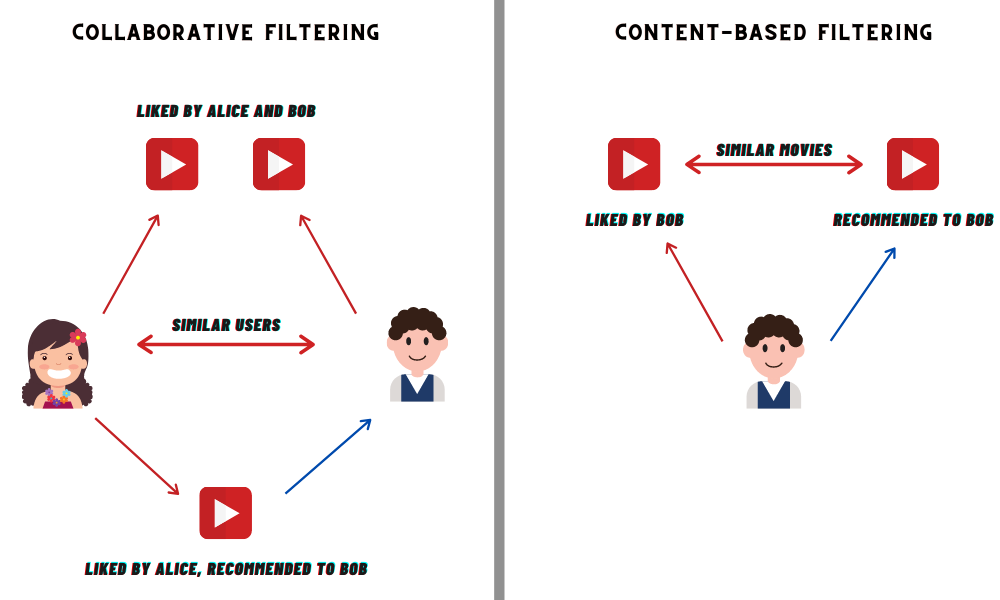

### 1.1 User Based Collaborative Filtering

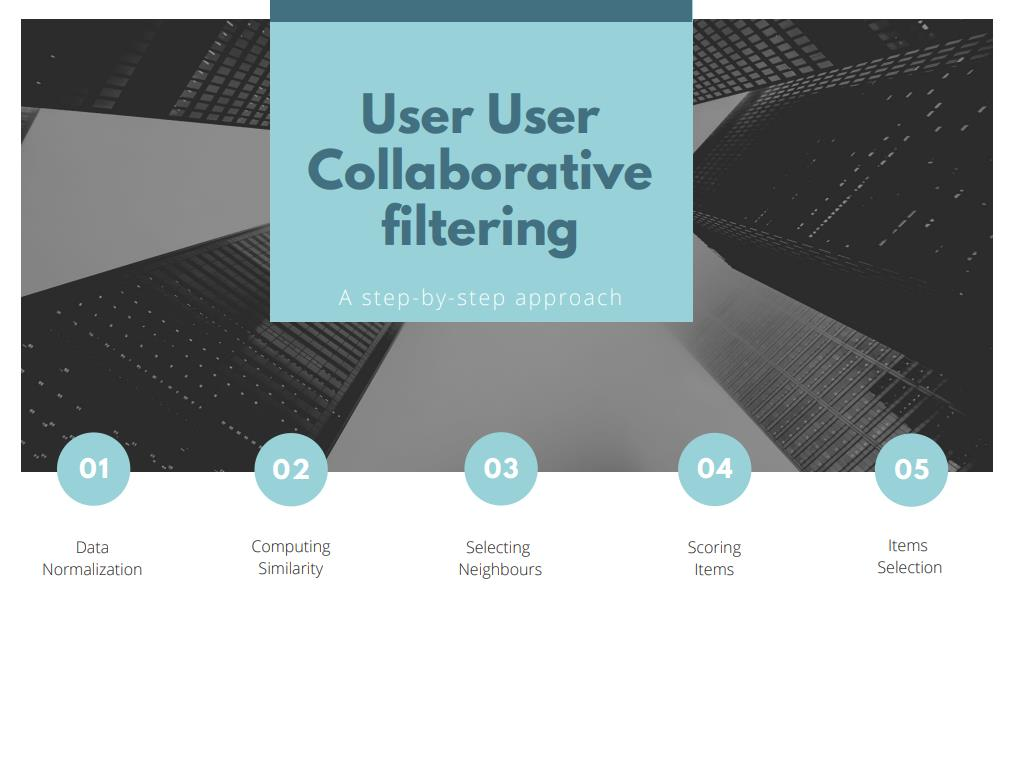

In **`K Nearest Neighbors`** for collaborative filtering, we use the number of $k$ people who most similar to the person we are looking for to find good recommendations. The best value for $k$ depends on the problem. 

We use **KNN with Means** algorithm for building user-based recommender system. This algorithm takes into account the mean ratings of each user. The prediction $\hat{r}_{ui}$ is set as:

$$\hat{r}_{ui} = \mu_u + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - \mu_v)} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)}$$

where $sim(u, v)$ is the similarity of two users $u$ and $v$. We use **cosine** similarity measure to compute the closeness of users with each other.

***Note***: The current implementation get neighbors of target user based on similarity measure. We find $k$ nearest neighbors and use their ratings to recommend the items to the target user. In this method, $k$ nearest neighbors for the target user is fixed and won't change(untill a new user or a new item added to the system). But if we want to determine $k$ nearest neighbors w.r.t each item, we should modify the current implementation. Uncommented code in the following class does the modification mentioned before. But due to memory limitation, it may not work efficiently and give satisfactory results.

In [13]:
class UserBasedCollaborativeFiltering():
    
    def __init__(self, users, books, ratings, k=10, max_rating=10.0):
        self.users = users
        self.users = self.users.reset_index()
        self.users = self.users.drop(columns=['index'])
        
        self.books = books
        
        self.ratings = ratings
        self.ratings = self.ratings.reset_index()
        self.ratings = self.ratings.drop(columns=['userId'])
        
        self.k = k
        self.max_rating = max_rating
    
    def normalize(self, dataframe):

        row_sum_ratings = dataframe.sum(axis=1) # sum entries of rows
        non_zero_count = dataframe.astype(bool).sum(axis=1) # count non-zero entries of rows 
        
        dataframe_mean = row_sum_ratings / non_zero_count # mean of rows
        
        self.normalized_ratings = dataframe.subtract(dataframe_mean, axis = 0) # subtract on rows(iteration over columns!)
    
    def compute_similarity(self, x, y):
        return np.dot(x, y)/ (np.linalg.norm(x) * np.linalg.norm(y))


    def create_similarity_matrix(self):          
        num_users = len(self.users)
        similarity_array = np.array([self.compute_similarity(self.ratings.iloc[i,:], self.ratings.iloc[j,:])
                                    for i in range(num_users) for j in range(num_users)])
        similarity_matrix = pd.DataFrame(data = similarity_array.reshape(self.users.shape[0], self.users.shape[0]))
        
        return similarity_matrix
    
    
#     def create_similarity_matrix(self):
#         num_users = len(self.users)
#         similarity_array = np.array([self.compute_similarity(self.ratings.iloc[i,:], self.ratings.iloc[j,:])
#                                     for i in range(num_users) for j in range(num_users)])
#         similarity_matrix = pd.DataFrame(data = similarity_array.reshape(self.users.shape[0], self.users.shape[0]),
#                                         index = self.users['userId'])
#         similarity_matrix.columns = self.users['userId']
#         return similarity_matrix
    

    def get_neighbors(self, user_id, similarity_matrix):
        user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
        user_similairities = similarity_matrix.iloc[user_index].values
        temp_neighbors_index = user_similairities.argsort()[-(self.k + 1):][::-1]
        neighbor_index = np.delete(temp_neighbors_index, np.where(temp_neighbors_index[user_index] == user_index))

        return neighbor_index    

#     def get_neighbors(self, user_id, similarity_matrix):
#         user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
#         user_similairities = similarity_matrix.iloc[user_index].values
#         temp_neighbors_index = user_similairities.argsort()[::-1]
#         similarity_indices = list(similarity_matrix.iloc[user_index].index)
#         neighbor_sim_scores = {}
#         for index in temp_neighbors_index:
#             if index != user_index:
#                 id = similarity_indices[index]
#                 neighbor_sim_scores[id] = user_similairities[index]
#         return neighbor_sim_scores
    
    
#     def get_raters(self, isbn):
#         raters = self.ratings[isbn]
#         user_ids = list(raters[raters != 0].index)
#         return user_ids
    
#     def get_unrated_books(self, user_id):
#         user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
#         all_books = self.ratings.iloc[user_index]
#         unrated_books = list(all_books[all_books == 0].index)
#         return unrated_books # ISBNs
        
    def score_item(self, user_id, neighbor_rating, neighbor_similarity, ratings):
        user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
        active_user_mean_rating = np.mean(ratings.iloc[user_index, :])
        score = np.dot(neighbor_similarity, neighbor_rating) + active_user_mean_rating
        data = score.reshape(1, len(score))
        columns = neighbor_rating.columns
        return pd.DataFrame(data= data , columns= columns)
    
    
#     def predict_scores(self, user_id, neighbor_sim_scores):
#         user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
#         unrated_books = self.get_unrated_books(user_id)      
#         num_neighbors = len(neighbor_sim_scores)
#         predicted_ratings = {}
#         for isbn in unrated_books:
#             neighbor_counter = 0
#             all_neighbors = []
#             k_nearest_neighbors = []
#             raters = self.get_raters(isbn)
#             for neighbor_id, sim_score in neighbor_sim_scores.items():
#                 if neighbor_id in raters:
#                     neighbor_counter += 1
#                     all_neighbors.append((neighbor_id, sim_score))
#             if neighbor_counter > self.k:
#                 k_nearest_neighbors = all_neighbors[: self.k]
#             else:
#                 k_nearest_neighbors = all_neighbors
#             predicted_score = self.compute_score(user_id, isbn, k_nearest_neighbors)
#             predicted_ratings[isbn] = predicted_score
#         return predicted_ratings
                        
#     def compute_score(self, user_id, isbn, neighbors):
#         user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
#         ids = [neighbor[0] for neighbor in neighbors]
#         sim_scores = [neighbor[1] for neighbor in neighbors]
#         nominator = 0
#         for id in ids:
#             nominator += similarity_matrix[id].iloc[user_id] * self.normalized_ratings[isbn].loc[id]
#         denominator = sum(sim_scores)
#         # no similarity score means there is no neighbor for this user and this means that Utility matrix is so sparse.
#         if denominator == 0: 
#             return -1
#         return nominator / denominator
            

    def recommend(self, user_id):
        user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
        user_ratings = book_ratings.iloc[user_index]
        recommendation_columns = []

        for i in range(len(user_ratings.index)):
            isbn = user_ratings.index[i]
            rating = user_ratings.values[i]
            if rating == 0.0:
                recommendation_columns.append(isbn)

        self.normalize(self.ratings)  
        similarity_matrix = self.create_similarity_matrix()
        neighbor_index = self.get_neighbors(user_id, similarity_matrix)
        neighbor_rating = self.normalized_ratings.loc[neighbor_index][recommendation_columns]
        neighbor_similarity = similarity_matrix[user_index].loc[neighbor_index]
        recommendation_score = self.score_item(user_id, neighbor_rating, neighbor_similarity, self.ratings)
        recommended_book_ISBNs = recommendation_score.stack().nlargest(self.k)
        recommended_book_ISBNs = [recommended_book_ISBNs.index.values[i][1] for i in range(len(recommended_book_ISBNs))]
        recommended_books = self.books.loc[self.books['ISBN'].isin(recommended_book_ISBNs)]

        return recommended_books
    
    
#     def recommend(self, user_id):
#         user_index = self.users.loc[self.users['userId'] == user_id].index.values[0]
#         user_ratings = book_ratings.iloc[user_index]
#         normalized_ratings= self.normalize(self.ratings)  
#         similarity_matrix = self.create_similarity_matrix()
#         neighbor_sim_scores = self.get_neighbors(user_id, similarity_matrix)
#         predicted_ratings = self.predict_scores(user_id, neighbor_sim_scores)
#         isbns_to_recommend = dict(sorted(predicted_ratings.items(), key=lambda item: item[1], reverse=True)[:self.k]).keys()
#         recommended_books = self.books.loc[self.books['ISBN'].isin(isbns_to_recommend)]    
#         return recommended_books

In [14]:
user_based_cf = UserBasedCollaborativeFiltering(sampled_users, sampled_books, book_ratings)

In [15]:
similarity_matrix = user_based_cf.create_similarity_matrix()

In [16]:
user_id = 23872
recommendations = user_based_cf.recommend(user_id)

In [17]:
recommendations.head(10)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
52,1558744150,Chicken Soup for the Woman's Soul (Chicken Sou...,Jack Canfield,1996,Health Communications
97,0842329129,Left Behind: A Novel of the Earth's Last Days ...,Tim Lahaye,1996,Tyndale House Publishers
134,0061009059,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,1995,HarperTorch
219,0345370775,Jurassic Park,Michael Crichton,1999,Ballantine Books
267,080410753X,The Kitchen God's Wife,Amy Tan,1992,Ivy Books
385,059035342X,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
489,0399146431,The Bonesetter's Daughter,Amy Tan,2001,Putnam Publishing Group
786,043935806X,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic
1726,0811801802,Sabine's Notebook: In Which the Extraordinary ...,Nick Bantock,1992,Chronicle Books
1779,0877017883,Griffin &amp; Sabine: An Extraordinary Corresp...,Nick Bantock,1991,Chronicle Books


Imagine you have an online music service that has an internal recommnder system. Where can the problem occur? 

Suppose this system has a million users. Every time you want to make an offer for a person, you have to compare the distance of this person with 999999 other people.

Now suppose we want to make several recommendations to different people every second. In this way, the calculations will be very complex and difficult. Except when you spend a lot of money to buy servers, the system will slow down. In more formal terms, latency can be a major problem in neighborhood-based recommender systems. Two main problems with working with user-based recommender systems are as follows:

**1- scalability**

As the number of users increases, so does the number of calculations. User-based methods may work well with thousands of users, but with millions of users, their "scalability" is problematic.


**2- sparsity**

Many of recommender systems have a large number of users and items. But each user, on average, rates a small percentage of their products. For example, Amazon has millions of books, but on average, the users have rated a handful of these books. For this reason, neighborhood-based algorithms may not be able to find any close neighbors for a person.

Because of these two problems, it is better to use **item-based filtering**.

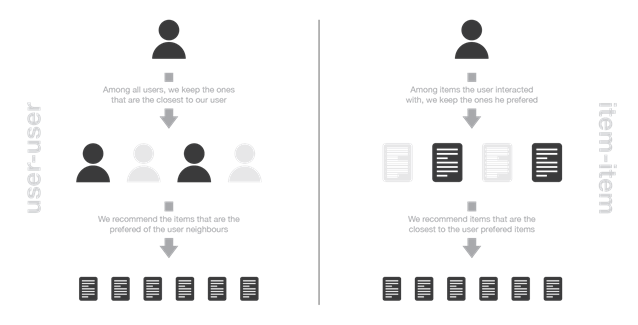

## 1.2 Item Based Collaborative Filtering

In the user-based method, we considered a user and were trying to find the person most similar to him / her among other users so that we can find recommendations for this user by the rating of the others. But in item-based filtering, before the recommendation time, we find the most similar items and combine them with user ratings so that we can form recommendations.

In this notebook, we use ***Weighted Slope One*** algorithm for item-based filtering. 

#### Wighted Slope One

In this algorithm, it's defined a concept called **deviation** for items. $\text{dev}_(i, j)$ is defined as the average difference between the ratings of $i$ and those of $j$:

$$\text{dev}(i, j) = \sum\limits_{u \in S_{i, j}(X)} \frac {u_{i} - u_{j}}{card(S_{i, j}(X))}$$

Where $card(S)$ is the number of elements in $S$ and $X$ is the number of all ratings. So $card(S_{i, j}(X))$ is the number of people who have rated both items $i$ and $j$.

After calculating the deviations between all items, we can use the following formula for predicting the rating of user $u$ to item $j$. The prediction $\hat{r}_{uj}$ is set as:

$$\hat{r}_{uj} = \frac {\sum\limits_{i \in S(u) - {j}} (\text{dev}(j, i) + u_{i})c_{j, i}}{\sum\limits_{i \in S(u) - {j}} c_{j, i}}$$

where $c_{j, i} = card(S_{i, j}(X))$.

In [18]:
class ItemBasedCollaborativeFiltering():    
    
    def __init__(self, users, books, ratings, k=10, max_rating=10.0):
        self.users = users
        self.users = self.users.reset_index()
        self.users = self.users.drop(columns=['index'])
        
        self.books = books
        
        self.ratings = ratings
        self.ratings = self.ratings.reset_index()
        self.ratings = self.ratings.drop(columns=['userId'])
        
        self.k = k
        self.max_rating = max_rating
        
        self.frequencies = {}
        self.deviations = {}
        
    
    def prepare_data(self):
                
        user_indices = list(self.ratings.index.values)

        users_ratings = []
        for user_index in user_indices:
            rated_book_indices = list(self.ratings.iloc[user_index].to_numpy().nonzero()[0])
            users_ratings.append({user_index: dict(self.ratings[self.ratings.columns[rated_book_indices]].iloc[user_index])})
    
        self.users_ratings = users_ratings
        
        return self.users_ratings
        
        
    def compute_deviations(self):
        users_ratings = self.users_ratings
        num_users = len(self.users)
        
        for i in range(num_users):
            for ratings in self.users_ratings[i].values():
                for item, rating in ratings.items():
                    self.frequencies.setdefault(item, {})
                    self.deviations.setdefault(item, {})
                    
                    for (item2, rating2) in ratings.items():
                        if item != item2:
                            self.frequencies[item].setdefault(item2, 0)
                            self.deviations[item].setdefault(item2, 0.0)
                            self.frequencies[item][item2] += 1
                            self.deviations[item][item2] += rating - rating2
            
            for (item, ratings) in self.deviations.items():
                for item2 in ratings:
                    ratings[item2] /= self.frequencies[item][item2]
    
    
    def slope_one_recommend(self, user_ratings):
        recommendations = {}
        frequencies = {}
        
        for (user_item, user_rating) in user_ratings.items():
        
            for (diff_item, diff_ratings) in self.deviations.items():
                if diff_item not in user_ratings and user_item in self.deviations[diff_item]:
                    freq = self.frequencies[diff_item][user_item]
                    recommendations.setdefault(diff_item, 0.0)
                    frequencies.setdefault(diff_item, 0)
        
                    recommendations[diff_item] += (diff_ratings[user_item] + user_rating) * freq
                    frequencies[diff_item] += freq
        
        recommendations = [(k, v / frequencies[k]) for (k, v) in recommendations.items()]
        
        recommendations.sort(key=lambda ratings: ratings[1], reverse = True)
        
        return recommendations
    
    
    def recommend(self, recommendations):
        top_k_recommendations = recommendations[: self.k]
        
        isbns = [recommendation[0] for recommendation in top_k_recommendations]
        
        recommended_books = [self.books.loc[self.books['ISBN'] == isbn] for isbn in isbns]
        return pd.concat(recommended_books)

In [19]:
item_based_cf = ItemBasedCollaborativeFiltering(sampled_users, sampled_books, book_ratings)

In [20]:
users_ratings = item_based_cf.prepare_data()

In [21]:
item_based_cf.compute_deviations()

In [22]:
user_index = 1
pd.DataFrame(sampled_users.iloc[user_index])

,1
userId,11676
age,39
city,n/a
state,n/a
country,n/a


In [23]:
recommendations = item_based_cf.slope_one_recommend(users_ratings[user_index][user_index])

In [24]:
item_based_cf.recommend(recommendations)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
2949,0385419287,The 776 Stupidest Things Ever Said,Ross Petras,1993,Main Street Books
1217,0140183515,Just So Stories (Penguin Twentieth-Century Cla...,Rudyard Kipling,1990,Penguin Books
1757,0394747232,Maus a Survivors Tale: My Father Bleeds History,Art Spiegelman,1986,Pantheon Books
3296,0373078110,Hidden Star (The Stars Of Mithra) (Harlequin ...,Nora Roberts,1997,Silhouette
2864,0373078358,Secret Star (The Stars Of Mithra) (Harlequin ...,Nora Roberts,1998,Silhouette
1183,0373218419,Blithe Images,Nora Roberts,2003,Silhouette
2791,0373218486,Going Home: Unfinished Business/ Island of Flo...,Nora Roberts,2002,Silhouette
2477,0373218540,Dangerous,Nora Roberts,2002,Silhouette
383,0373242328,The Perfect Neighbor (The Macgregors) (The Mac...,Nora Roberts,1999,Silhouette
1553,0373243286,"Irish Rebel (Special Edition, 1328)",Nora Roberts,2000,Silhouette


## 2. Content-based Filtering

**Content-based filtering**, also referred to as **cognitive filtering**, recommends items based on a comparison between the content of the items and a user profile. The content of each item is represented as a set of descriptors or terms, typically the words that occur in a document. A content-based recommender works with data that the user provides, either explicitly (rating) or implicitly (clicking on a link). Based on that data, a user profile is generated, which is then used to make recommendations to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

After cleaning and preparing the data, we can use **`TF-IDF`** representation to make our recommender system.

**TF** is simply the frequency of a word in a document. **IDF** is the inverse of the document frequency among the whole corpus of documents. TF-IDF is used mainly because of two reasons: Suppose we search for “the rise of analytics” on Google. It is certain that “the” will occur more frequently than “analytics” but the relative importance of analytics is higher than the search query point of view. In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

Here is a funny description of TF-IDF representation:

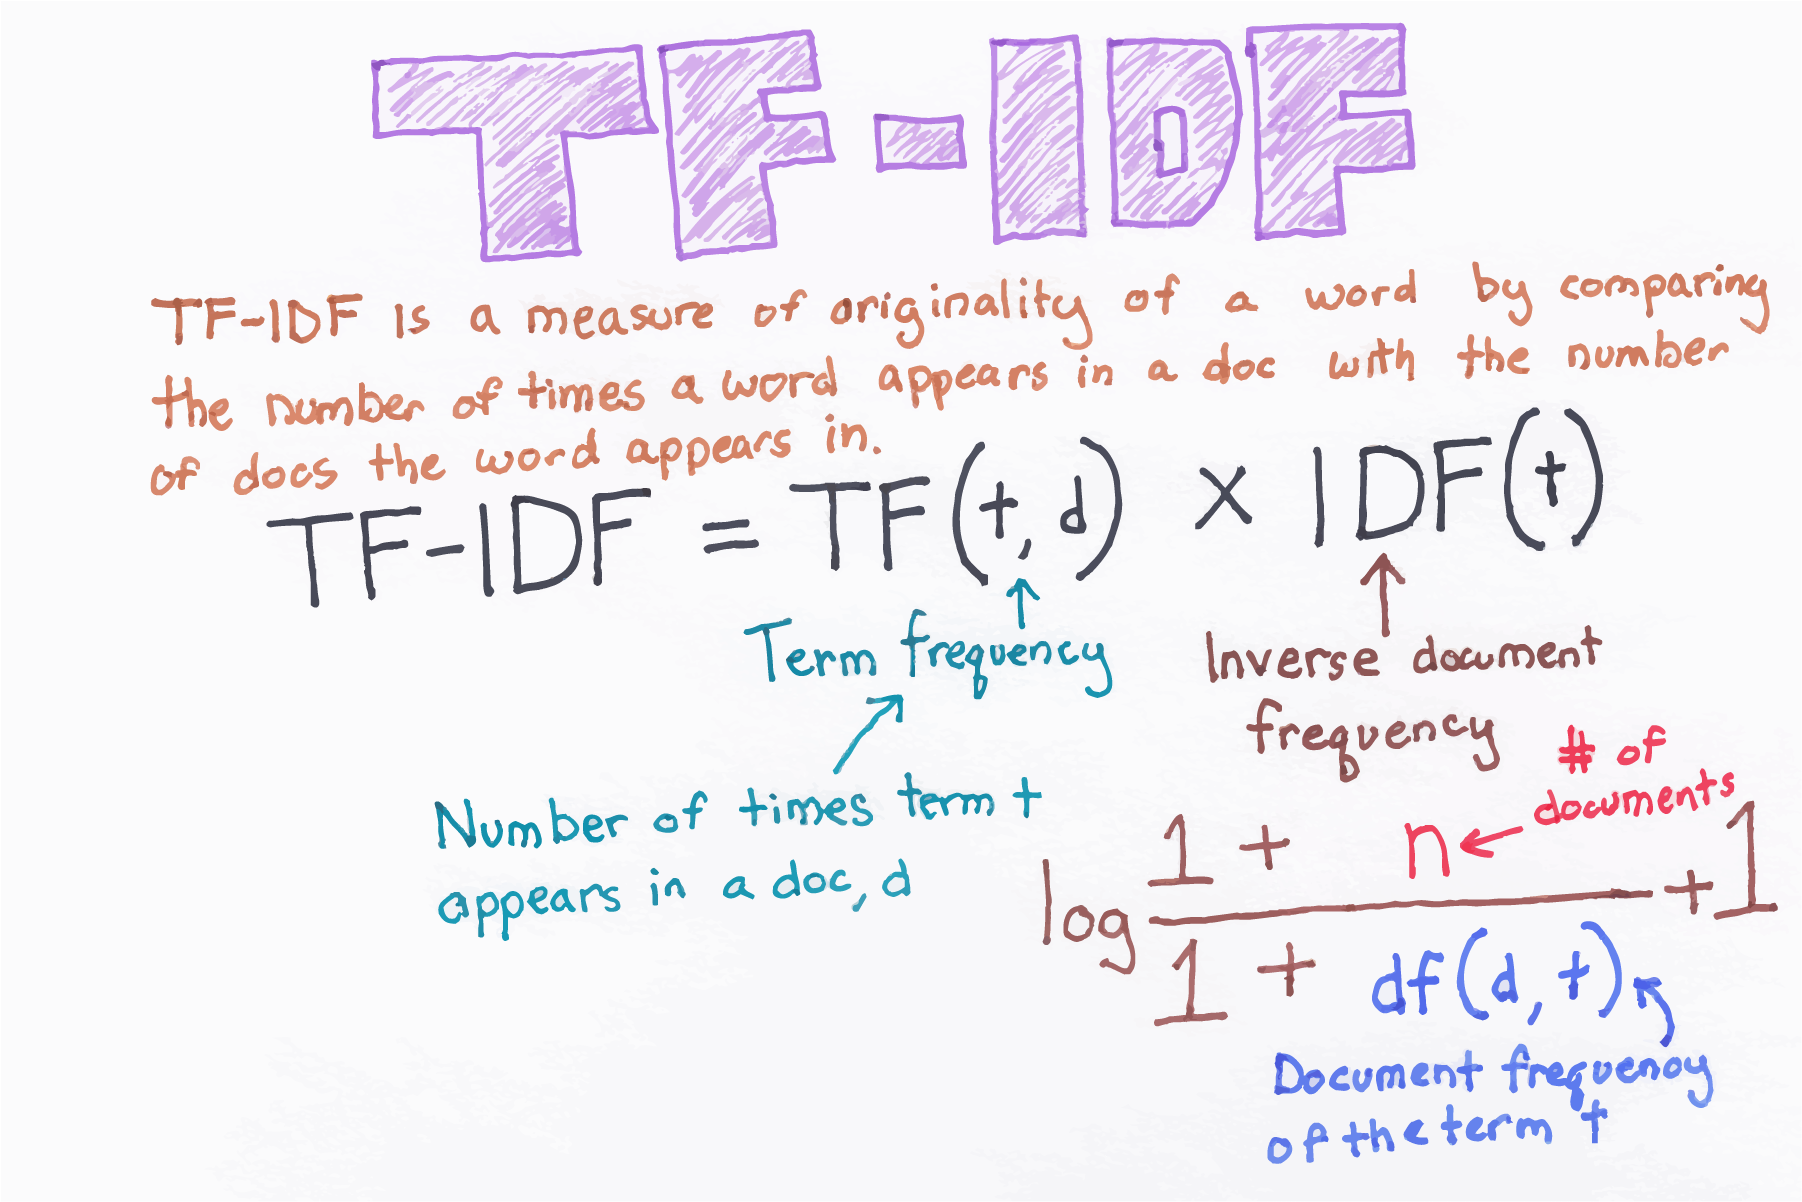

In [64]:
class ContentBasedFiltering():
    
    def __init__(self, books, ratings, k = 10):
        self.ratings = ratings
        self.books = self.prepare_data(books)
        self.tfidf_matrix = self.create_embedding_matrix()
        self.sigmoid = self.create_kernel()
        self.indices = self.create_indices()
        self.k = k
        
        
    def clean(self, text, combine=False):
        text = text.lower()
        text = re.sub('[^a-z0-9 ]', '', text)
        
        if combine:
            return ''.join(t.replace(' ', '') for t in text).strip()
        
        return text.strip()
    
    
    def prepare_data(self, books, rating_threshold = 2):
        
        # select books that has been rated
        rated_books = books[books.ISBN.isin(ratings.ISBN)]
        
        # remove duplicates based on bookTitle
        unique_books = rated_books.drop_duplicates(subset = ['bookTitle'], keep = False)
        
        # if rating count of a book > rating_threshold, then the book will be selected.
        popular_ISBN = list(self.ratings.ISBN.value_counts()[self.ratings.ISBN.value_counts() >= rating_threshold].index)
        
        # Only keep the books that its rating count is > rating_threshold; this means that it is popular.
        popular_books = unique_books[unique_books.ISBN.isin(popular_ISBN)]
        
        popular_books['bookTitleClean'] = popular_books['bookTitle'].map(lambda x: self.clean(x, combine=False))
        
        popular_books['spaghetti'] = popular_books['bookTitleClean']
        
        return popular_books 
    
    
    def create_embedding_matrix(self):
        from sklearn.feature_extraction.text import TfidfVectorizer
        
        self.books['spaghetti'] = self.books['spaghetti'].fillna('')
        self.books = self.books.reset_index()

        tfidf_vectorizer = TfidfVectorizer(
#             min_df = 3, 
#             max_features = None, 
#             strip_accents = 'unicode', 
#             analyzer = 'word',
#             token_pattern = r'\w{1,}',
#             ngram_range = (1, 3),
            stop_words = 'english'
        )

        tfidf_matrix = tfidf_vectorizer.fit_transform(self.books['spaghetti'])
        print('tf-idf embedding matrix shape = ' + str(tfidf_matrix.shape))
        
        return tfidf_matrix
    
    def create_kernel(self):
        return sigmoid_kernel(self.tfidf_matrix, self.tfidf_matrix)
        
    
    def create_indices(self):
        return pd.Series(self.books.index, index = self.books['bookTitle']).drop_duplicates()
    
    
    def recommend(self, query):
        
        idx = self.indices[query]

        sigmoid_scores = list(enumerate(self.sigmoid[idx]))
        sigmoid_scores = sorted(sigmoid_scores, key=lambda x: x[1], reverse=True)
        sigmoid_scores = sigmoid_scores[1: self.k + 1]
        
        book_indices = [i[0] for i in sigmoid_scores]
        
        recommendations =  pd.DataFrame(self.books.iloc[book_indices])
        recommendations = recommendations.drop(columns=['index', 'bookTitleClean', 'spaghetti'])
        
        return recommendations

In [65]:
content_based_cf = ContentBasedFiltering(sampled_books, sampled_ratings)

tf-idf embedding matrix shape = (3624, 4741)


In [66]:
query = 'Wild Animus'
content_based_cf.recommend(query)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
277,0385486804,Into the Wild,Jon Krakauer,1997,Anchor
428,1559029838,Call of the Wild,Jack London,1994,Selldowns/no More Orders
2616,0515132292,Wild,Lori Foster,2002,Jove Books
2060,1551668777,So Wild A Heart,Candace Camp,2002,Mira
3247,0843953004,Wild Desire,Phoebe Conn,2003,Leisure Books
3390,0399149279,Wild Pitch,Mike Lupica,2002,Putnam Publishing Group
2612,0743437128,Wild Orchids : A Novel,Jude Deveraux,2003,Atria Books
907,0380812037,On a Wild Night (Cynster Novels),Stephanie Laurens,2002,Avon
1858,0373240880,Waiting For Nick (Those Wild Ukrainians) (Sil...,Nora Roberts,1997,Silhouette
957,0671769316,NEW ROADSIDE AMERICA : THE MODERN TRAVELER'S G...,Doug Kirby,1992,Fireside


## 3. Machine Learning based Model

### Sampling Data(Candidate Generation)

In [36]:
quality_book = ratings['ISBN'].value_counts().rename_axis('ISBN').reset_index(name = 'Count')
quality_book = quality_book[quality_book['Count'] > 5]['ISBN'].to_list()
quality_ratings = ratings[ratings['ISBN'].isin(quality_book)]
quality_ratings

,userId,ISBN,bookRating
8,276744,038550120X,7
16,276747,0060517794,9
19,276747,0671537458,9
20,276747,0679776818,8
28,276754,0684867621,8
...,...,...,...
1149743,276688,0836218655,10
1149744,276688,0836236688,10
1149761,276704,0345386108,6
1149771,276704,0743211383,7


In [37]:
quality_user = quality_ratings['userId'].value_counts().rename_axis('userId').reset_index(name = 'Count')
quality_user = quality_user[quality_user['Count']>5]['userId'].to_list()
quality_ratings = quality_ratings[quality_ratings['userId'].isin(quality_user)]
quality_ratings

,userId,ISBN,bookRating
174,276847,3257200552,5
177,276847,3404148576,8
179,276847,3423071516,10
182,276847,3426029553,8
186,276847,3442413508,10
...,...,...,...
1149715,276688,0553575104,6
1149738,276688,0688156134,8
1149739,276688,0743202694,10
1149743,276688,0836218655,10


In [38]:
quality_user = quality_ratings['userId'].value_counts().rename_axis('userId').reset_index(name = 'Count')
quality_user = quality_user[quality_user['Count']>5]['userId'].to_list()
quality_ratings = quality_ratings[quality_ratings['userId'].isin(quality_user)]
quality_ratings

,userId,ISBN,bookRating
174,276847,3257200552,5
177,276847,3404148576,8
179,276847,3423071516,10
182,276847,3426029553,8
186,276847,3442413508,10
...,...,...,...
1149715,276688,0553575104,6
1149738,276688,0688156134,8
1149739,276688,0743202694,10
1149743,276688,0836218655,10


In [39]:
book_ratings = quality_ratings.pivot_table(index='userId', columns='ISBN', values='bookRating').fillna(0)

In [40]:
user_id_list = book_ratings.index.tolist()
column_names = ["userId", "location", "age"]
sampled_users = pd.DataFrame(columns = column_names)
sampled_users = users.loc[users['userId'].isin(user_id_list)]
sampled_users = sampled_users.reset_index()
sampled_users = sampled_users.drop(['index'], axis=1)

sampled_users.head()

,userId,age,city,state,country
0,114,57,ligonier,pennsylvania,usa
1,243,23,arden hills,minnesota,usa
2,244,29,college station,texas,usa
3,254,24,minneapolis,minnesota,usa
4,388,35,nashville,tennessee,usa


In [41]:
book_isbn_list = book_ratings.columns.values.tolist()
column_names = ["ISBN", "bookTitle", "bookAuthor", "yearOfPublication", "publisher"]
sampled_books = pd.DataFrame(columns = column_names)
sampled_books = books.loc[books['ISBN'].isin(book_isbn_list)]
sampled_books = sampled_books.reset_index()
sampled_books = sampled_books.drop(['index'], axis=1)
sampled_books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
3,0440234743,The Testament,John Grisham,1999,Dell
4,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume


### Rating Normalization(Gaussian Normalization)

$${R}^{u_{i}}_{norm}(b) = \frac {R_{b} - R^{u_{i}}_{mean}}{\sqrt {\sum\limits_{j} (R_{b_{j}} - R^{u_{i}}_{mean})}}$$

In [42]:
mean_rating_user = quality_ratings.groupby('userId')['bookRating'].mean().reset_index(name='Mean-Rating-User')
mean_data = pd.merge(quality_ratings, mean_rating_user, on='userId')
mean_data['Diff'] = mean_data['bookRating'] - mean_data['Mean-Rating-User']
mean_data['Square'] = (mean_data['Diff'])**2
norm_data = mean_data.groupby('userId')['Square'].sum().reset_index(name='Mean-Square')
norm_data['Root-Mean-Square'] = np.sqrt(norm_data['Mean-Square'])
mean_data = pd.merge(norm_data, mean_data, on='userId')
mean_data['Norm-Rating'] = mean_data['Diff']/(mean_data['Root-Mean-Square'])  
mean_data['Norm-Rating'] = mean_data['Norm-Rating'].fillna(0)
max_rating = mean_data.sort_values('Norm-Rating')['Norm-Rating'].to_list()[-1]
min_rating = mean_data.sort_values('Norm-Rating')['Norm-Rating'].to_list()[0]
mean_data['Norm-Rating'] = 5*(mean_data['Norm-Rating'] - min_rating)/(max_rating-min_rating)
mean_data['Norm-Rating'] = np.ceil(mean_data['Norm-Rating']).astype(int)
norm_ratings = mean_data[['userId','ISBN','Norm-Rating']]
mean_data.sort_values('Norm-Rating')

,userId,Mean-Square,Root-Mean-Square,ISBN,bookRating,Mean-Rating-User,Diff,Square,Norm-Rating
55125,124989,0.956522,0.978019,0061092096,9,9.956522,-0.956522,0.914934,0
106081,247429,0.956522,0.978019,0842314296,9,9.956522,-0.956522,0.914934,0
114902,270121,10.000000,3.162278,0020442203,6,8.000000,-2.000000,4.000000,1
60439,136313,13.500000,3.674235,006016848X,6,9.250000,-3.250000,10.562500,1
114894,270069,50.500000,7.106335,0375401598,2,6.500000,-4.500000,20.250000,1
...,...,...,...,...,...,...,...,...,...
81525,188589,2.857143,1.690309,0804106304,9,7.857143,1.142857,1.306122,5
74264,170693,3.500000,1.870829,0515126772,7,5.500000,1.500000,2.250000,5
77999,179532,5.333333,2.309401,0575400188,9,7.333333,1.666667,2.777778,5
109655,256270,3.500000,1.870829,0385504209,9,7.500000,1.500000,2.250000,5


### Model Selection

In [43]:
reader = surprise.Reader(rating_scale=(0, 5))
data = surprise.Dataset.load_from_df(norm_ratings[['userId', 'ISBN', 'Norm-Rating']], reader)

In [44]:
benchmark = []

algorithms = [surprise.SVD(), surprise.SVDpp(), surprise.SlopeOne(), surprise.NMF(), surprise.NormalPredictor(), surprise.KNNBaseline(), surprise.KNNBasic(), surprise.KNNWithMeans(), surprise.KNNWithZScore(), surprise.BaselineOnly(), surprise.CoClustering()]

print ("Attempting: ", str(algorithms), '\n\n\n')

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

print ('\n\tDONE\n')

Attempting:  [<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x0000027A06FC0FA0>, <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x0000027A06FC0700>, <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x0000027A06FC0D60>, <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x0000027A06FC0430>, <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x0000027A06FC06D0>, <surprise.prediction_algorithms.knns.KNNBaseline object at 0x0000027A0A8830D0>, <surprise.prediction_algorithms.knns.KNNBasic object at 0x0000027A0A8830A0>, <surprise.prediction_algorithms.knns.KNNWithMeans object at 0x0000027A06FAE5B0>, <surprise.prediction_algorithms.knns.KNNWithZScore object at 0x0000027A06FAE6A0>, <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x0000027A06FAE6D0>, <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x0000027A06FAE3D0>] 



Starting:  <surprise.prediction_algorithms.

In [45]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.623102,0.621864,0.497632
SVD,0.638414,11.182843,1.068117
SVDpp,0.642247,326.426530,11.014257
KNNBasic,0.651084,3.699362,2.695200
KNNBaseline,0.657459,5.371754,3.776943
KNNWithMeans,0.716738,5.410559,4.121958
KNNWithZScore,0.730334,5.712449,3.559501
SlopeOne,0.743389,15.904352,5.569202
NMF,0.753540,15.133519,0.760018


### Model Creation and Training

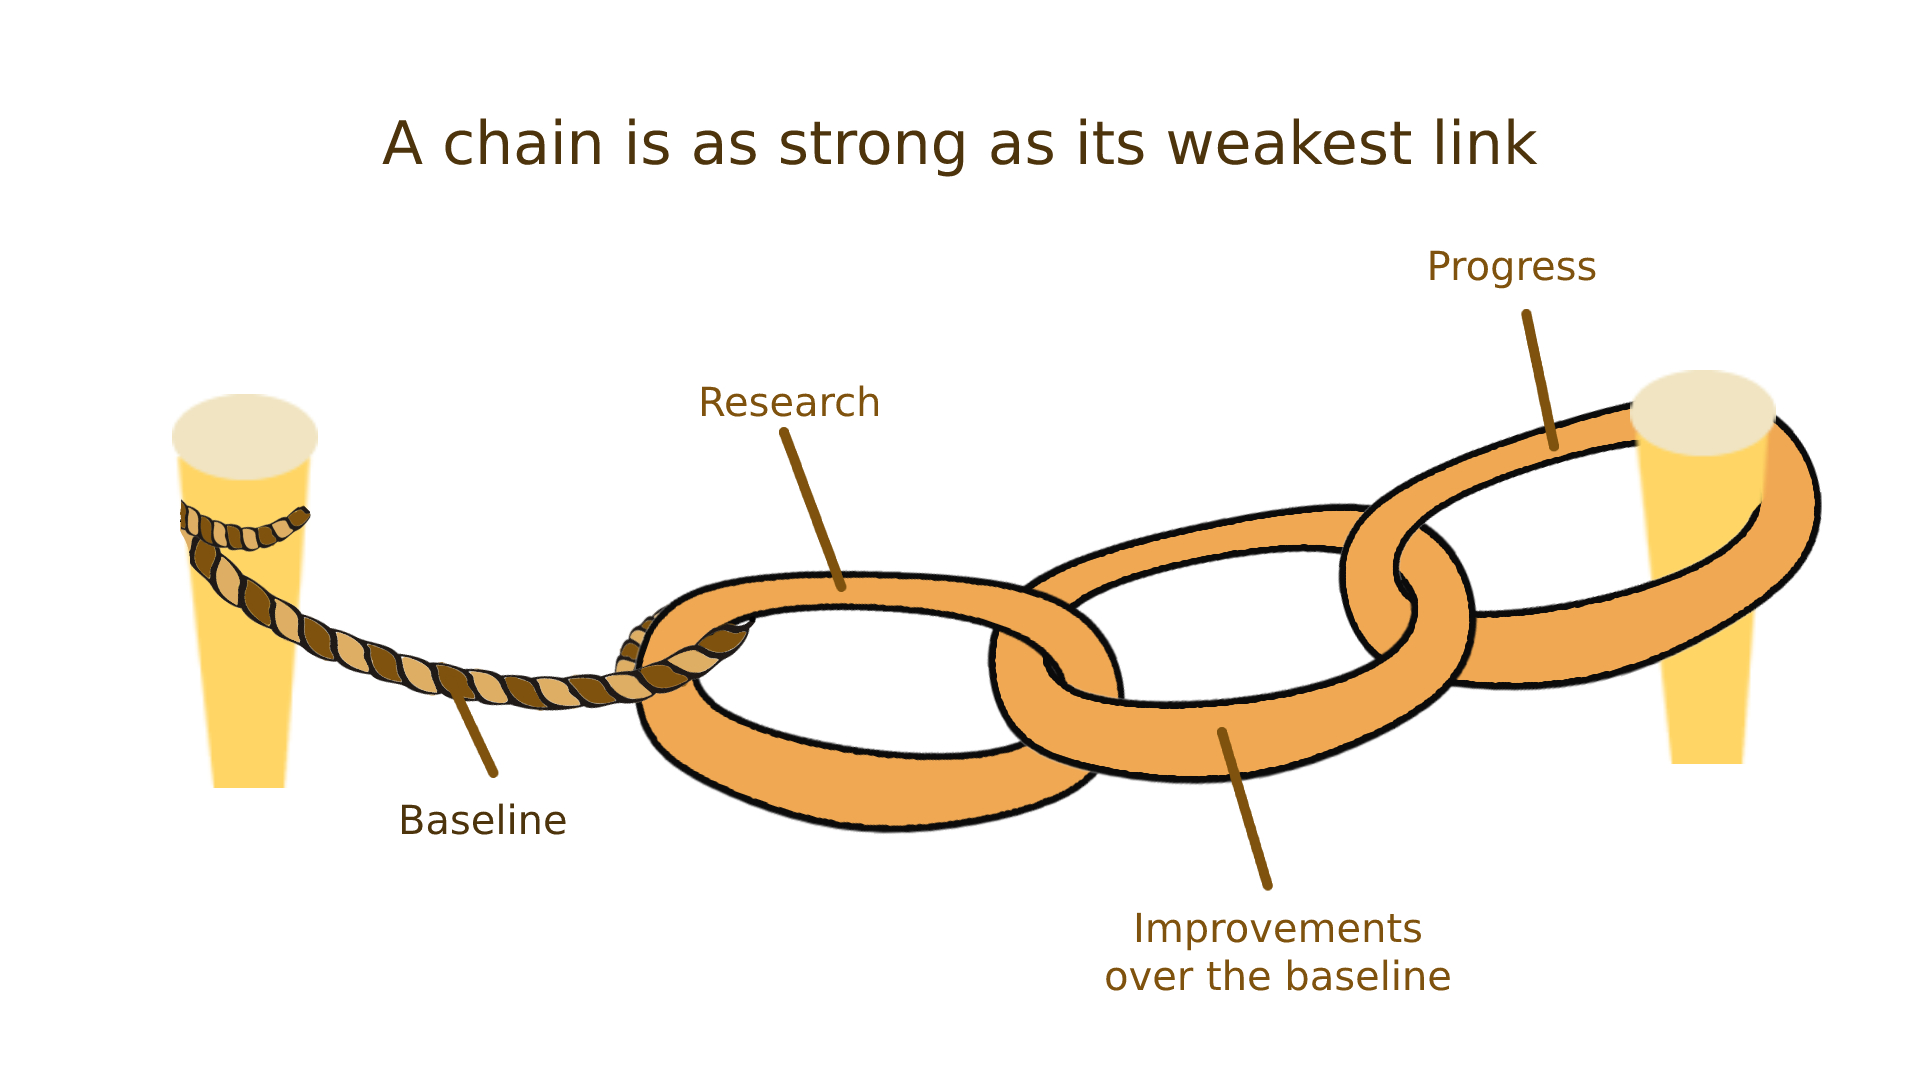

Due to the previous section, we choose ***Baseline Only*** algorithm which predicts the baseline estimate for given user and item.

***Note***: A *`baseline`* is a fixed point of reference that is used for comparison purposes.

$$\hat{r}_{ui} = b_{ui} = \mu + b_u + b_i$$

where $b_{u}$ and $b_{i}$ are the estimation biases for user and item, respectively.

If user $u$ is unknown, then the bias $b_{u}$ is assumed to be 0. The same applies for item $i$ with $b_{i}$.

Baselines can be estimated in two different ways:

- **Stochastic Gradient Descent (SGD)**
- **Alternating Least Squares (ALS)**

We use SGD procedure for this notebook.

In [46]:
from surprise.model_selection import train_test_split
from surprise import accuracy
train_set, test_set = train_test_split(data, test_size=0.25)
baseline = surprise.BaselineOnly(bsl_options={'method': 'sgd','learning_rate': .00005, 'n_epochs':30, 'reg':0.5})
fit = baseline.fit(train_set)
predictions = fit.test(test_set)
accuracy.rmse(predictions)

Estimating biases using sgd...
RMSE: 0.6169


0.6169023314184883

In [47]:
recommend = baseline.trainset
users_norm = list(set(norm_ratings['userId'].to_list()))
books_norm = list(set(norm_ratings['ISBN'].to_list()))
norm_ratings['userId'].unique()

array([   114,    243,    244, ..., 278582, 278633, 278843], dtype=int64)

In [48]:
pred_users = [user for user in users_norm if recommend.knows_user(recommend.to_inner_uid(user))]
pred_books = []
for book in books_norm:
    try:
        if recommend.knows_item(recommend.to_inner_iid(book)):
            pred_books.append(book)
    except:
        pass

### Model Evaluation

In [49]:
def recommend_books(user_id, count):
    result=[]
    for b in pred_books:
        result.append([b, baseline.predict(user_id,b,r_ui=4).est])
    recom = pd.DataFrame(result, columns=['ISBN','Rating'])
    merge = pd.merge(recom,books, on='ISBN' )
    return merge.sort_values('Rating', ascending=False).head(count)

In [50]:
user_id = '36938'
top_k = 10
recommendation = recommend_books(user_id, top_k)

### Scoring

In [51]:
scoring = recommendation.sort_values('yearOfPublication')
scoring

,ISBN,Rating,bookTitle,bookAuthor,yearOfPublication,publisher
1679,0446310786,3.043888,To Kill a Mockingbird,Harper Lee,1988,Little Brown &; Company
4581,0812550706,3.030365,Ender's Game (Ender Wiggins Saga (Paperback)),Orson Scott Card,1994,Tor Books
8461,0312195516,3.036624,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
9413,059035342X,3.038730,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,1999,Arthur A. Levine Books
968,0671027360,3.032492,Angels &amp; Demons,Dan Brown,2001,Pocket Star
3698,0316666343,3.054502,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
7002,0385504209,3.062642,The Da Vinci Code,Dan Brown,2003,Doubleday
30,0142001740,3.048681,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
8390,0156027321,3.030434,Life of Pi,Yann Martel,2003,Harvest Books
2982,043935806X,3.028746,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic


## References

1.  ***A Programmer’s Guide to Data Mining: The Ancient Art of the Numerati***
2. https://surprise.readthedocs.io/en/stable/slope_one.html#surprise.prediction_algorithms.slope_one.SlopeOne
3. https://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly
4. https://towardsdatascience.com/user-user-collaborative-filtering-for-jokes-recommendation-b6b1e4ec8642
5. https://www.kaggle.com/benroshan/content-collaborative-anime-recommendation
6. https://www.kaggle.com/akhilram7/book-recommendations-at-scale